# Collaboration and Competition


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


In [46]:
import numpy as  np
#Setting random seed for reproducibility
np.random.seed(0) 
import sys
import random
#Setting random seed
random.seed(0)

import torch
#Setting random seed
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from maddpg import MADDPG
from config_file import Config
from utils import plot_reward

from unityagents import UnityEnvironment
import numpy as np

from collections import deque

%reload_ext autoreload

%autoreload 2

In [7]:
#Config
config = Config()

config.display()


Configurations:
BATCH_SIZE                     512
BUFFER_SIZE                    1000000
NUM_NEURONS_LAYER1             512
NUM_NEURONS_LAYER2             256
NUM_UPDATES                    2
UPDATE_EVERY                   1
gamma                          0.99
learning_rate_actor            0.0001
learning_rate_critic           0.0001
tau                            0.2




In [8]:
#Device type (use cuda if gpu is available else cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initializing MultiAgent
maddpg_agent = MADDPG(state_size, action_size,
                      num_agents, config)

In [9]:
episodes = 2000                                         # Max no. of episodes   
scores = []                                             # list containing scores from each episode
scores_window = deque(maxlen=100)

for i_episode in range(1,episodes+1):
    
    env_info = env.reset(train_mode=True)[brain_name]   # reset the environment
    states = env_info.vector_observations               # get the current state
    score = np.zeros(num_agents)                        # scores for each agent
    
    step = 0

    while True:
        
        actions = maddpg_agent.act(states, step)        # select an action
        
        env_info = env.step(actions)[brain_name]        # send the action to the environment
        
        next_states = env_info.vector_observations      # get the next state
        
        rewards = (np.array(env_info.rewards)
                  .reshape(num_agents,1))               # get the reward
        
        dones = (np.array(env_info.local_done)
                 .reshape(num_agents,1))                # see if episode has finished
        
        maddpg_agent.step(states[None,:,:],             # Update Agent's attributes(Replay buffer/parameters)
                          actions[None,:,:], 
                          rewards[None,:,:],     
                          next_states[None,:,:], 
                          dones[None,:,:])
        score += rewards.ravel()                        # update the score
        
        states = next_states                            # roll over the state to next time step
        
        step += 1                                      
         
        if np.any(dones):                               # exit loop if episode finished is by any agent
            break
        
    
    scores_window.append(np.max(score))                 # save most recent score
    scores.append(np.max(score))                        # save most recent score
    
    sys.stdout.flush()
    print('\rEpisode {}\tAverage Score: {:.2f}'\
          .format(i_episode,
                  np.mean(scores_window)), end="")
    
    
    if np.mean(scores_window) >= 0.5 :
        
        maddpg_agent_dict = {}
        
        for i, agent in enumerate(maddpg_agent.agents):
            
            maddpg_agent_dict.update(
           {f'actor_main_network_state_dict_agent_{i}' : agent.actor_main.state_dict(),
            f'actor_target_network_state_dict_agent_{i}' : agent.actor_target.state_dict(),
            f'critic_main_network_state_dict_agent_{i}' : agent.critic_main.state_dict(),
            f'critic_target_network_state_dict_agent_{i}' : agent.critic_target.state_dict(),
            f'optimizer_actor_state_dict_agent_{i}' : agent.optimizer_actor.state_dict(),
            f'optimizer_critic_state_dict_agent_{i}' : agent.optimizer_actor.state_dict()

           })
            
        # Saving Weights
        torch.save( maddpg_agent_dict,
                    'maddpg_agent_state.pt')
        
        
        print("\n Problem Solved!")

        break
    
print("Score: {}".format(score))

Episode 841	Average Score: 0.51
 Problem Solved!
Score: [ 1.69000003  1.80000003]


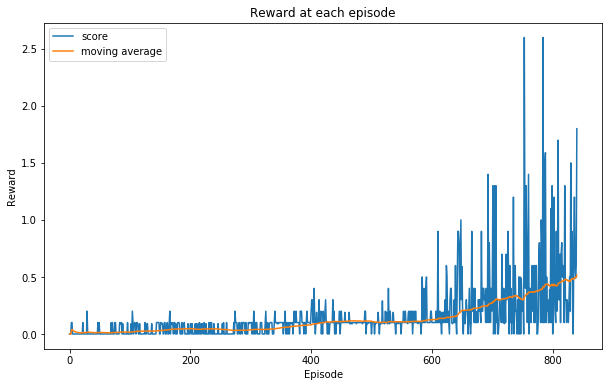

In [49]:
#Plotting Rewards
fig=plt.figure(figsize = (10,6))
plot_reward(scores)

In [50]:
def test(num_episodes=100):
    
    all_scores = []

    from tqdm import tqdm
    
    for ep in tqdm(range(num_episodes)):

        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = maddpg_agent.act(states)                        # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break

        all_scores.append(np.max(scores))
        
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(all_scores)))
    
test(num_episodes = 100)

100%|██████████| 100/100 [06:36<00:00,  4.34s/it]

Total score (averaged over agents) this episode: 2.281600034032017
